In [13]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import jax
import numpy as np
import matplotlib.pyplot as plt
from confirm.lewislib import lewis
import confirm.imprint as ip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
name = "1d_slice"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
    "bad_arm": -1.0,
}

In [36]:
class Model1D:
    def __init__(self, seed, max_K, **kwargs):
        self.model = lewis.Lewis45Model(
            0, 2**18, **{k: v for k, v in kwargs.items() if k != "bad_arm"}
        )
        self.bad_arm = kwargs["bad_arm"]
        self.family = "binomial"
        self.family_params = {"n": int(self.model.lewis45.unifs_shape()[0])}

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control = theta[:, 0]
        theta = np.stack(
            (control, control, control, np.full_like(control, self.bad_arm)), axis=1
        )
        null_truth = np.full((theta.shape[0], 3), True)
        return self.model.sim_batch(begin_sim, end_sim, theta, null_truth)


# model = Model1D(0, 2**18, **params)
# stats = model.sim_batch(0, 1000, np.array([[0]]), None)

In [40]:
g = ip.cartesian_grid([-1], [1], n=[64])
rej_df = ip.validate(Model1D, g, lam=0.06253, K=2**16, model_kwargs=params)

In [41]:
rej_df

,tie_sum,tie_est,tie_cp_bound,tie_bound
0,164,0.002502,0.002995,0.004685
1,183,0.002792,0.003311,0.005171
2,180,0.002747,0.003261,0.005110
3,197,0.003006,0.003542,0.005545
4,203,0.003098,0.003641,0.005707
...,...,...,...,...
59,1257,0.019180,0.020464,0.029661
60,1220,0.018616,0.019881,0.028800
61,1195,0.018234,0.019487,0.028198
62,1136,0.017334,0.018557,0.026858


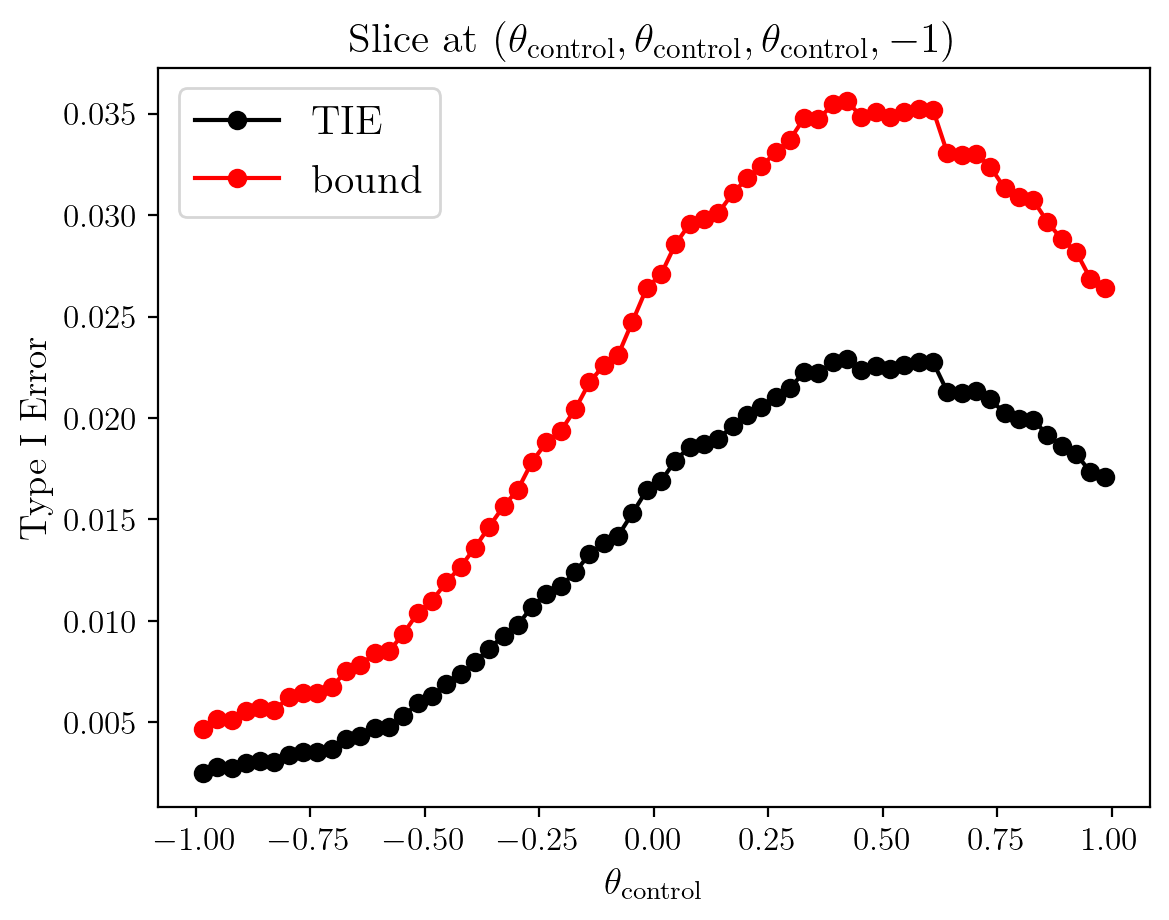

In [49]:
plt.plot(g.df["theta0"], rej_df["tie_est"], "k-o", label="TIE")
plt.plot(g.df["theta0"], rej_df["tie_bound"], "r-o", label="bound")
plt.xlabel("$\\theta_{\mathrm{control}}$")
plt.ylabel("Type I Error %")
plt.legend()
plt.title(
    "Slice at $(\\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, \\theta_{\mathrm{control}}, -1)$"
)
plt.show()